[<img src="data/photutils_banner.svg" width=300 alt="">](http://photutils.readthedocs.io/en/stable/index.html)

# Background Estimation with `photutils`
---

##### What is background estimation?
In order to most accurately do photometric analysis of celestial sources in image data, it is important to estimate and subtract the image background. Any astronomical image will have background noise, due to both detector effects and background emission from the night sky. This noise can be modeled as uniform, or as varying with position on the detector. 

The `photutils` package provides tools for estimating 2-dimensional background noise, which can then be subtracted from an image to ensure the most accurate photometry possible.

##### What does this tutorial include?
This tutorial covers the basics of background estimation and subtraction, including the following methods:
- Scalar Background Estimation
- 2-D Background Estimation

The methods demonstrated here are available in narrative form within the `photutils.background` [documentation](http://photutils.readthedocs.io/en/stable/background.html).

<div class="alert alert-block alert-info">**Note:** This notebook focuses on global background estimation. Local background subtraction with <b>annulus apertures</b> is demonstrated in the [aperture photometry notebook](03_photutils_aperture_photometry.ipynb).</div><div class="alert alert-block alert-warning">**Important:** Before proceeding, please be sure to install or update your [AstroConda](https://astroconda.readthedocs.io) distribution. This notebook may not work properly with older versions of AstroConda.</div>

---

## Import necessary packages

First, let's import packages that we will use to perform arithmetic functions and visualize data:

In [70]:
import numpy as np

from astropy.io import fits
from astropy.nddata import NDData
import astropy.units as u
from astropy.stats import sigma_clipped_stats, SigmaClip
from astropy.visualization import ZScaleInterval, ImageNormalize

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# Show plots in the notebook
% matplotlib inline

Let's also define some `matplotlib` parameters, to make sure our plots look nice. (See [here](https://matplotlib.org/users/customizing.html) to learn more about customizing `matplotlib`.)

In [71]:
matplotlib.rc('font', family='serif', weight='light', size=12)
matplotlib.rc('mathtext', bf='serif:normal')
matplotlib.rc('axes', titlesize=20, titlepad=12, labelsize=18)
matplotlib.rc('xtick', labelsize=16)
matplotlib.rc('ytick', labelsize=16)
matplotlib.rc('text', usetex=True)
matplotlib.rc('figure', dpi=100)

## Retrieve data

For this example, we will be using Hubble eXtreme Deep Field (XDF) data, collecting using the Advanced Camera for Surveys (ACS) on Hubble between 2002 and 2012 and totalling 1.8 million seconds (500 hours!) of exposure time.

We have placed the data for this tutorial in the github repository, for easy access. The data were originally retrieved from the STScI archive: https://archive.stsci.edu/prepds/xdf/

In [142]:
with fits.open('data/hlsp_xdf_hst_acswfc-60mas_hudf_f435w_v1_sci_backgroundadded.fits') as hdulist:
    hdulist.info()
    data = hdulist[0].data
    header = hdulist[0].header

Filename: data/hlsp_xdf_hst_acswfc-60mas_hudf_f435w_v1_sci_backgroundadded.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   (5250, 5250)   float32   


We are going to transport the data using a `NDData` object (see [Astropy documentation](http://docs.astropy.org/en/stable/api/astropy.nddata.NDData.html)), which contains a `numpy` array in addition to metadata such as uncertainty, masks, or units. In this case, our data is in electrons (counts) per second.

In [143]:
unit = u.ct / u.s
nddata = NDData(data, unit=unit, meta=header)

Let's look at the data:

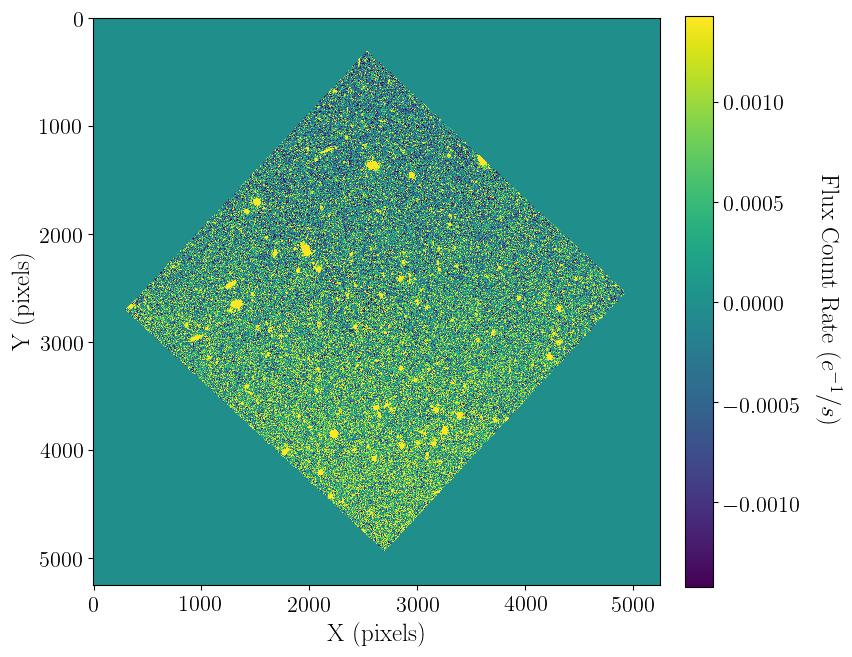

In [102]:
# Set up the figure with subplots
fig, ax1 = plt.subplots(1, 1, figsize=(8, 8))

# Plot the data
norm_image = ImageNormalize(nddata.data, interval=ZScaleInterval())
fitsplot = ax1.imshow(nddata.data, norm=norm_image)

# Define the colorbar
cbar = plt.colorbar(fitsplot, fraction=0.046, pad=0.04)

# Define labels
cbar.set_label(r'Flux Count Rate ($e^{-1}/s$)', rotation=270, labelpad=30)
ax1.set_xlabel('X (pixels)')
ax1.set_ylabel('Y (pixels)')

plt.show()

## Mask data

You probably noticed that a large portion of the data is equal to zero. The data we are using is a reduced mosaic that combines many different exposures, and that has been rotated such that not all of the array holds data. 

We want to **mask** out the non-data, so all of those pixels that have a value of zero don't interfere with our statistics and analyses of the data.

In [161]:
# Define the mask
nddata.mask = nddata.data == 0

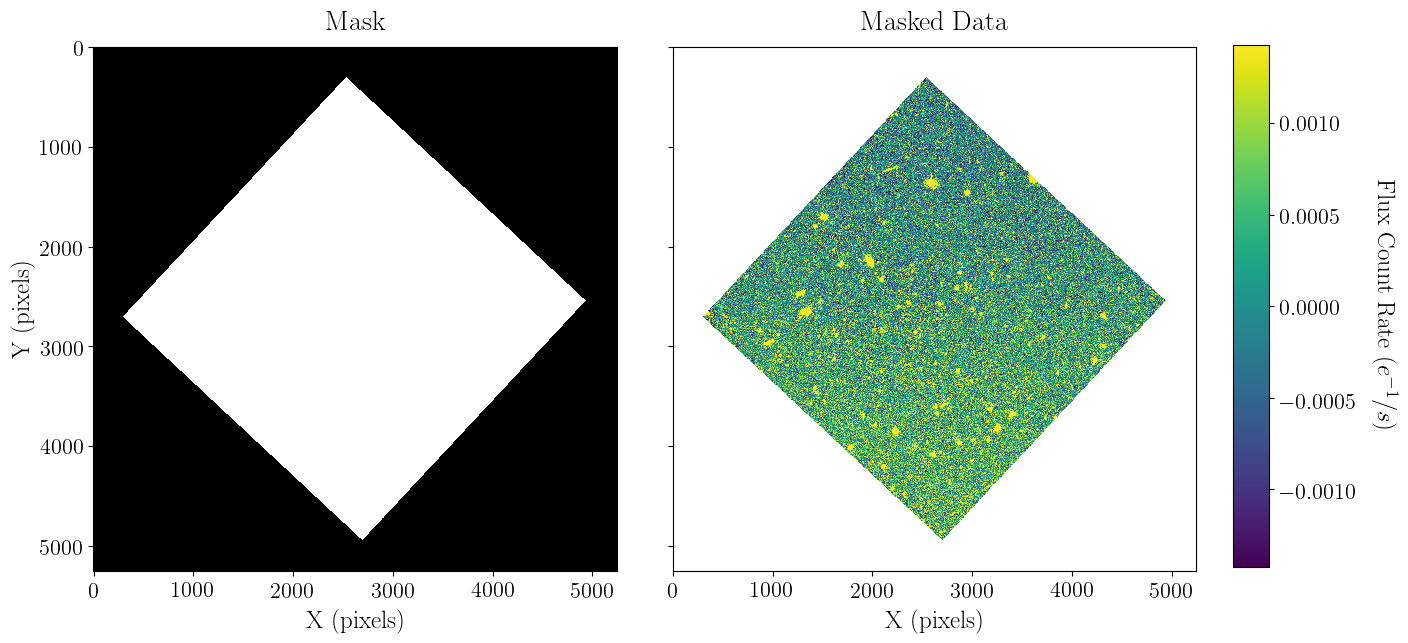

In [150]:
# Set up the figure with subplots
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
plt.tight_layout()

# Plot the mask
ax1.imshow(nddata.mask, cmap='Greys')
ax1.set_xlabel('X (pixels)')
ax1.set_ylabel('Y (pixels)')
ax1.set_title('Mask')

# Plot the masked data
norm_image = ImageNormalize(nddata.data, interval=ZScaleInterval())
fitsplot = ax2.imshow(np.ma.masked_where(nddata.mask, nddata.data), norm=norm_image)
cbar_ax = fig.add_axes([1, 0.09, 0.03, 0.87])
cbar = fig.colorbar(fitsplot, cbar_ax)
cbar.set_label(r'Flux Count Rate ($e^{-1}/s$)', rotation=270, labelpad=30)
ax2.set_xlabel('X (pixels)')
ax2.set_title('Masked Data')

plt.show()

## Perform scalar background estimation

Now that the data are properly masked, we can calculate some basic statistical values to do a scalar estimation of the image background.

Here we will calculate the mean, median, and mode using sigma clipping. With sigma clipping, the data is iteratively clipped to exclude data points outside of a certain sigma (standard deviation), thus removing some of the noise from the data before determining statistical values.

In [77]:
mean, median, std = sigma_clipped_stats(nddata.data, sigma=3.0, iters=5, mask=nddata.mask)

But what difference does this sigma clipping make? And how important is masking, anyway? Let's visualize these statistics to get an idea:

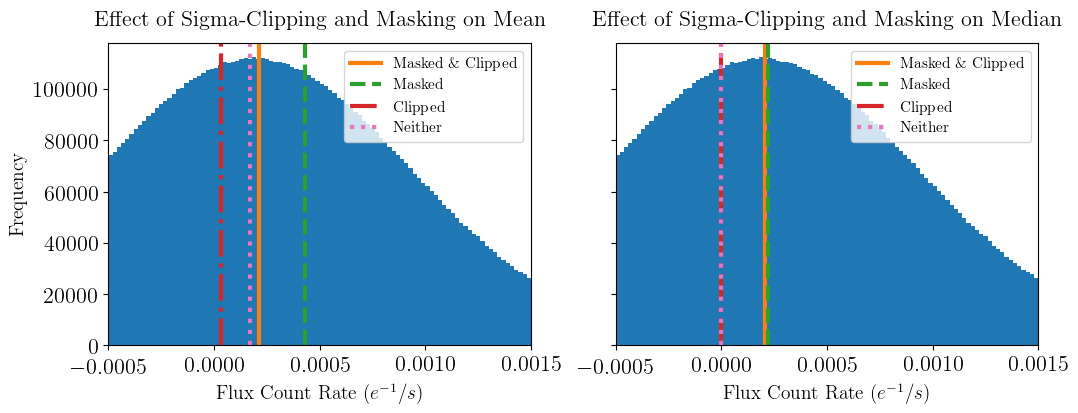

In [166]:
# Set up the figure with subplots
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# Plot histograms of the data
flux_range = (-.5e-3, 1.5e-3)
ax1.hist(nddata.data[~nddata.mask], bins=100, range=flux_range)
ax2.hist(nddata.data[~nddata.mask], bins=100, range=flux_range)

# Plot lines for each kind of mean
ax1.axvline(mean, label='Masked \& Clipped', c='C1', lw=3)
ax1.axvline(np.average(nddata.data[~nddata.mask]), label='Masked', c='C2', ls='--', lw=3)
ax1.axvline(stats_nomask[0], label='Clipped', c='C3', ls='-.', lw=3)
ax1.axvline(np.average(nddata.data), label='Neither', c='C6', ls=':', lw=3)

ax1.set_xlim(flux_range)
ax1.set_xlabel(r'Flux Count Rate ($e^{-1}/s$)', fontsize=14)
ax1.set_ylabel('Frequency', fontsize=14)
ax1.set_title('Effect of Sigma-Clipping and Masking on Mean', fontsize=16)
ax1.legend(fontsize=11)


# Plot lines for each kind of median
ax2.axvline(median, label='Masked \& Clipped', c='C1', lw=3)
ax2.axvline(np.median(nddata.data[~nddata.mask]), label='Masked', c='C2', ls='--', lw=3)
ax2.axvline(stats_nomask[1], label='Clipped', c='C3', ls='-.', lw=3)
ax2.axvline(np.median(nddata.data), label='Neither', c='C6', ls=':', lw=3)

ax2.set_xlim(flux_range)
ax2.set_xlabel(r'Flux Count Rate ($e^{-1}/s$)', fontsize=14)
ax2.set_title('Effect of Sigma-Clipping and Masking on Median', fontsize=16)
ax2.legend(fontsize=11)


plt.show()

Just from simply looking at the distribution of the data, it is pretty easy to see how sigma-clipping and masking improve the calculation of the mean and median.

But enough looking at numbers, let's actually remove the background from the data.

In [81]:
data_scalarsubtraction = nddata.data - mean

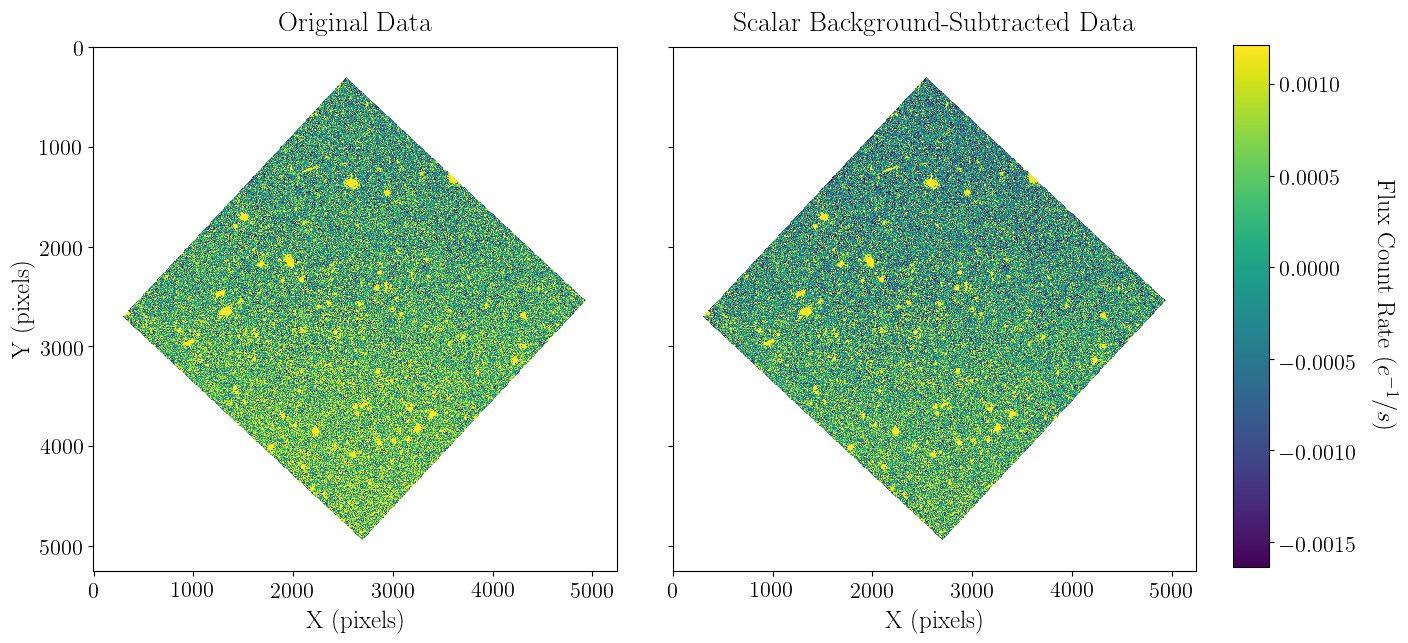

In [85]:
# Set up the figure with subplots
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
plt.tight_layout()

# Define the normalization based on the scalar background-subtracted data
norm_image = ImageNormalize(data_scalarsubtraction, interval=ZScaleInterval())

# Plot the original data
fitsplot = ax1.imshow(np.ma.masked_where(nddata.mask, nddata.data), norm=norm_image)
# ax1.text(0.05, 0.95, 'SNR = $\mu/\sigma$ = {:.2}'.format(snr_old), transform=ax1.transAxes, fontsize=14)
ax1.set_xlabel('X (pixels)')
ax1.set_ylabel('Y (pixels)')
ax1.set_title('Original Data')

# Plot the subtracted data
fitsplot = ax2.imshow(np.ma.masked_where(nddata.mask, data_scalarsubtraction), norm=norm_image)
# ax2.text(0.05, 0.95, 'SNR = $\mu/\sigma$ = {:.2}'.format(snr_new), transform=ax2.transAxes, fontsize=14)
cbar_ax = fig.add_axes([1, 0.09, 0.03, 0.87])
cbar = fig.colorbar(fitsplot, cbar_ax)
cbar.set_label(r'Flux Count Rate ($e^{-1}/s$)', rotation=270, labelpad=30)
ax2.set_xlabel('X (pixels)')
ax2.set_title('Scalar Background-Subtracted Data')

plt.show()

That looks much better! However, the background still does not seem to be completely removed. In this case, the background varies spatially; it is 2-dimensional. Thankfully, `photutils` includes functions to remove background like this.

## Perform 2-D background estimation

The `Background2D` class allows users to model 2-dimensional backgrounds, by evaluating the background signal in small boxes, and smoothing these boxes to reconstruct a continuous 2D background. The class includes the following arguments/attributes:
* **`box_size`** - the size of the boxes used to calculate the background. This should be larger than individual sources, yet still small enough to encompass changes in the background.
* **`filter_size`** - the size of the median filter used to smooth the final 2D background.
* **`filter_threshold`** - threshold below which the smoothing median filter will not be applied.
* **`sigma_clip`** - an ` astropy.stats.SigmaClip` object that is used to specify the sigma and number of iterations used to sigma-clip the data before background calculations are performed.
* **`bkg_estimator`** - the method used to perform the background calculation in each box (mean, median, SExtractor algorithm, etc.).

For this example, we will use the `MeanBackground` estimator.

In [86]:
from photutils.background import Background2D, MeanBackground

In [168]:
sigma_clip = SigmaClip(sigma=3., iters=5)
bkg_estimator = MeanBackground()
bkg = Background2D(nddata.data, box_size=200, filter_size=(10, 10), mask=nddata.mask,
                   sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)

So, what does this 2D background look like? Where were the boxes placed?

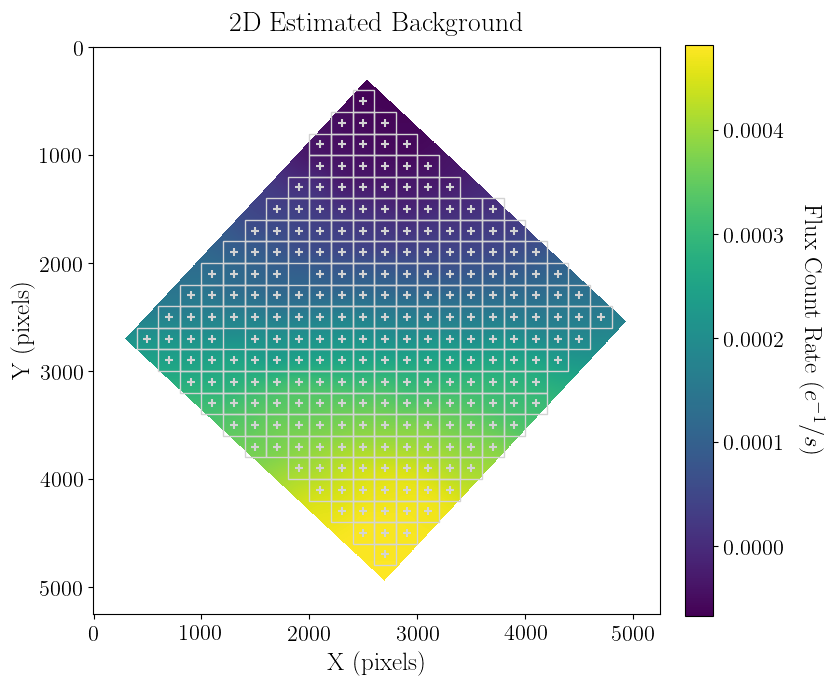

In [100]:
# Set up the figure with subplots
fig, ax1 = plt.subplots(1, 1, figsize=(8, 8))

# Plot the data
norm_image = ImageNormalize(bkg.background, interval=ZScaleInterval())
fitsplot = ax1.imshow(np.ma.masked_where(nddata.mask, bkg.background), norm=norm_image)

# Plot the meshes
bkg.plot_meshes(outlines=True, color='lightgrey')

# Define the colorbar
cbar = plt.colorbar(fitsplot, fraction=0.046, pad=0.04)

# Define labels
cbar.set_label(r'Flux Count Rate ($e^{-1}/s$)', rotation=270, labelpad=30)
ax1.set_xlabel('X (pixels)')
ax1.set_ylabel('Y (pixels)')
ax1.set_title('2D Estimated Background')

plt.show()

And how does the data look if we use this background subtraction method?

In [89]:
data_2Dsubtraction = nddata.data - bkg.background

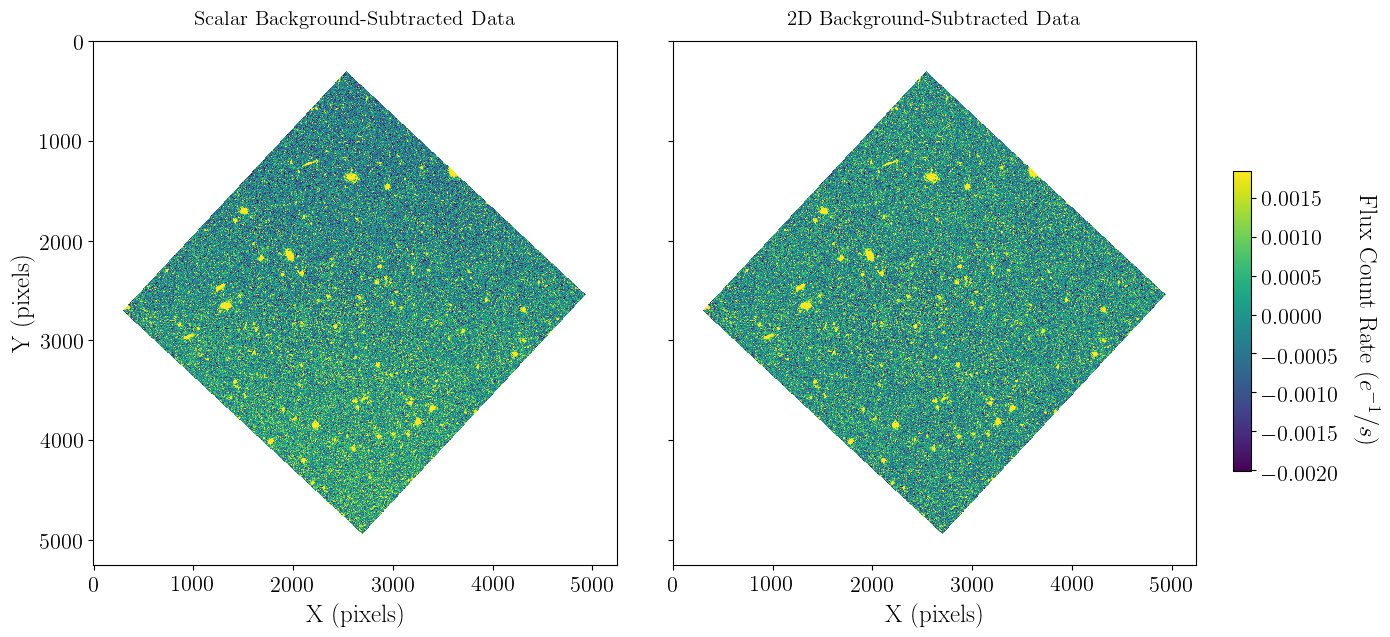

In [106]:
# Set up the figure with subplots
fig, [ax2, ax3] = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
plt.tight_layout()

# Define the normalization based on the 2D background-subtracted data
norm_image = ImageNormalize(data_2Dsubtraction, interval=ZScaleInterval())

# # Plot the original data
# fitsplot = ax1.imshow(np.ma.masked_where(nddata.mask, nddata.data), norm=norm_image)
# # ax1.text(0.05, 0.95, 'SNR = $\mu/\sigma$ = {:.2}'.format(snr_old), transform=ax1.transAxes, fontsize=14)
# ax1.set_xlabel('X (pixels)')
# ax1.set_ylabel('Y (pixels)')
# ax1.set_title('Original Data', fontsize=15)

# Plot the scalar-subtracted data
fitsplot = ax2.imshow(np.ma.masked_where(nddata.mask, data_scalarsubtraction), norm=norm_image)
# ax2.text(0.05, 0.95, 'SNR = $\mu/\sigma$ = {:.2}'.format(snr_new), transform=ax2.transAxes, fontsize=14)
cbar.set_label(r'Flux Count Rate ($e^{-1}/s$)', rotation=270, labelpad=30)
ax2.set_ylabel('Y (pixels)')
ax2.set_xlabel('X (pixels)')
ax2.set_title('Scalar Background-Subtracted Data', fontsize=15)

# Plot the 2D-subtracted data
fitsplot = ax3.imshow(np.ma.masked_where(nddata.mask, data_2Dsubtraction), norm=norm_image)
# ax3.text(0.05, 0.95, 'SNR = $\mu/\sigma$ = {:.2}'.format(snr_new), transform=ax2.transAxes, fontsize=14)
cbar_ax = fig.add_axes([1, 0.24, 0.015, 0.5])
cbar = fig.colorbar(fitsplot, cbar_ax)
cbar.set_label(r'Flux Count Rate ($e^{-1}/s$)', rotation=270, labelpad=30)
ax3.set_xlabel('X (pixels)')
ax3.set_title('2D Background-Subtracted Data', fontsize=15)

plt.show()

The difference here is more subtle than the difference between the original data and the scalar background-subtracted data, but note the difference between these two images in the bottom corner and top corner.

## Conclusions

The `photutils` package provides a powerful tool in the `Background2D` class, allowing users to easily estimate and subtract spatially variant background signals from their data.

##### To continue with this `photutils` tutorial, go on to the [source detection notebook](02_photutils_source_detection.ipynb).

## Exercises
---

1) Perform a median scalar background subtraction on our sigma-clipped data.

2) Perform a 2D background subtraction using the `MedianBackground` estimator.

3) Compare the scalar background subtraction to the 2D background subtraction. Which is better?

4) Compare the median background subtraction to the mean background subtraction. Which is better?

---
<i>May 2018

Author: Lauren Chambers (lchambers@stsci.edu)

For more examples and details, please visit the [photutils](http://photutils.readthedocs.io/en/stable/index.html) documentation.</i>